### 라이브러리 불러오기

In [1]:
import os
import cv2
import PIL
import math
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from IPython.display import display
from keras_ocr.detection import Detector
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

### 라이브러리 버전 확인하기

In [2]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


In [3]:
# gpu 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [5]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [6]:
def detect_text(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = PIL.Image.fromarray(img)
    img_draw = PIL.ImageDraw.Draw(img_pil)
    result_img = img_pil.copy()
    
    img = np.expand_dims(img, axis=0)
    detection_result = detector.detect(img)
    ocr_result = detection_result[0]
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

In [7]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args # labels: 정답 라벨, y_pred: 모델이 예측한 출력, label_length: 각 라벨의 실제 길이, input_length: 각 입력 시퀀스의 길이
    y_pred = y_pred[:, 2:, :] # 모델 출력 y_pred의 초기 두 타임스텝 제거 (CTC 손실 계산을 위한 사전처리)
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("완료")

완료


In [8]:
# CRNN 모델을 만드는 함수
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2 # 총 문자 수(36) + 시작,종료 구분용 추가 문자(2) = 38
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # CNN 부분
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    # RNN 부분
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # ctc loss를 위한 추가 입력
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    
    # ctc 손실 계산 레이어
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    
    # 모델 정의
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("완료")

완료


In [9]:
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [10]:
def recognize_img(model, pil_img, input_img_size=(100,32)):
    pil_imgs = pil_img.copy()
    img = pil_imgs.resize(input_img_size, PIL.Image.ANTIALIAS)
    img_array = np.array(img).astype(np.float32)
    if len(img_array.shape) == 2: img_array = np.expand_dims(img_array, axis=-1)
    img_array = np.transpose(img_array, (1, 0, 2))
    img_input = np.expand_dims(img_array, axis=0)

    output = model.predict(img_input)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(PIL.Image.fromarray(img_input[0].transpose(1,0,2).astype(np.uint8)))

In [11]:
result_img, cropped_imgs = detect_text(SAMPLE_IMG_PATH)

In [12]:
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

model = build_crnn_model()
model.load_weights(checkpoint_path)

input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = tf.keras.Model(inputs=input_data, outputs=y_pred)

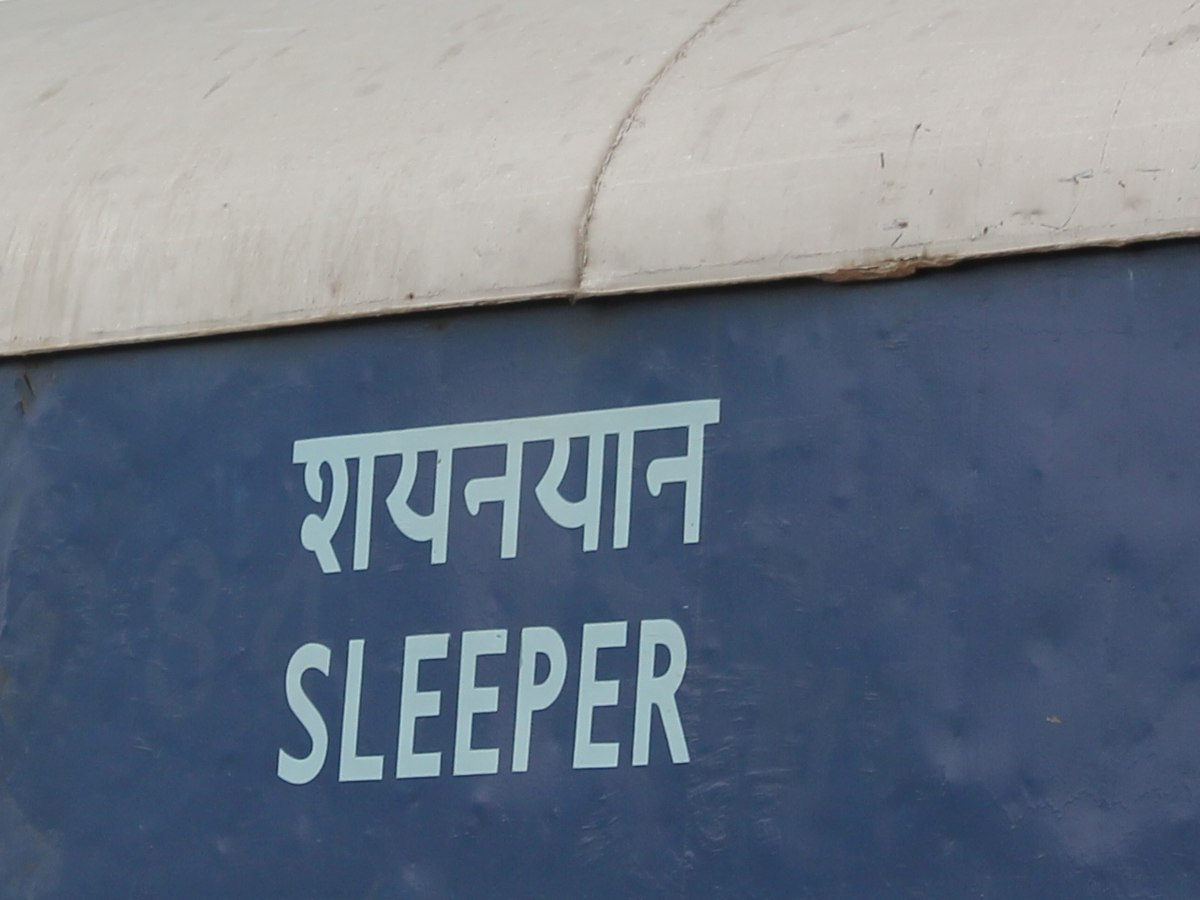

In [13]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Result: 	 SVRUPRUA9999999999999999


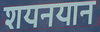

Result: 	 SLEEPER9999999999999999


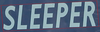

In [15]:
for _img in cropped_img:
    recognize_img(model_pred, _img)

---
---
---

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from tensorflow.keras.models import Model

def visualize_feature_map(model, layer_name, input_image):
    
    # 특정 레이어 출력으로 모델 생성
    intermediate_model = Model(inputs=model.input[0], outputs=model.get_layer(layer_name).output)
    
    # 피처맵 생성
    feature_map = intermediate_model.predict(input_image)
    
    print(f"Feature map shape: {feature_map.shape}")
    
    # 피처맵 시각화
    num_filters = feature_map.shape[-1]  # 필터 수
    size = feature_map.shape[1]  # 피처맵의 공간적 크기 (H, W)
    
    # 첫 8개 필터만 시각화 (필요에 따라 조정 가능)
    plt.figure(figsize=(15, 15))
    for i in range(min(8, num_filters)):
        plt.subplot(1, 8, i+1)
        plt.imshow(feature_map[0, :, :, i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.show()

In [17]:
# 입력 이미지 준비
input_image = np.expand_dims(SAMPLE_IMG_PATH[0], axis=0)  # 첫 번째 이미지 사용

# 시각화하고 싶은 레이어 이름
layer_name = 'conv2d_1'  # 예: Conv2D 레이어 이름

# 피처맵 시각화
visualize_feature_map(model_pred, layer_name, input_image)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: tf.__operators__.getitem/strided_slice:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 100, 32, 3), dtype=tf.float32, name='input_image'), name='input_image', description="created by layer 'input_image'") at layer "conv2d". The following previous layers were accessed without issue: []